In [126]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from scipy import sparse 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

In [127]:
#set seed
np.random.seed(912)

# Xây dựng mô hình

In [128]:
def softmax_stable(Z):
    """
    Sử dụng softmax_stable để tránh tràn số  
    """
    e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
    A = e_Z / e_Z.sum(axis = 0)
    return A

def convert_labels(y, C):
    """
    Biến vector y thành ma trận one-hot
    """
    Y = sparse.coo_matrix((np.ones_like(y), 
        (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y 

def loss_function(X, Y, W):
    """
    Tính hàm mất mát cross-entropy loss
    """
    A = softmax_stable(W.T.dot(X))
    return -np.sum(Y*np.log(A))

def softmax_regression(X, y, W_init, eta, tol = 1e-4, max_count = 50000):
    """
    Softmax Regression sử dụng Stochastic Gradient Descent (SGD)
    """
    W = [W_init]    
    C = W_init.shape[1]
    Y = convert_labels(y, C)
    it = 0
    N = X.shape[1]
    d = X.shape[0]
    
    count = 0
    check_w_after = 20
    while count < max_count:
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)
            ai = softmax_stable(np.dot(W[-1].T, xi))
            W_new = W[-1] + eta*xi.dot((yi - ai).T)
            count += 1
            # Điều kiện dừng
            if count%check_w_after == 0:                
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
    return W

def pred(W, X):
    """
    Dự đoán nhãn cho tập dữ liệu X
    """
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis = 0)

# Áp dụng vào bài toán

## Chuẩn bị dữ liệu huấn luyện

In [129]:
df = pd.read_csv('data/obesity_data_cleaned.csv') 
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad
0,1,24.0,1.70,81.67,1,1,2.000000,2.983297,1,2.763573,0.000000,0.976473,1,0,0,0,1,0,6
1,0,18.0,1.56,57.00,1,1,2.000000,3.000000,2,2.000000,1.000000,1.000000,0,1,0,0,0,0,1
2,0,18.0,1.71,50.17,1,1,1.880534,1.411685,1,1.910378,0.866045,1.673584,0,0,0,0,1,0,0
3,0,20.0,1.71,131.27,1,1,3.000000,3.000000,1,1.674061,1.467863,0.780199,1,0,0,0,1,0,4
4,1,31.0,1.91,93.80,1,1,2.679664,1.971472,1,1.979848,1.967973,0.931721,1,0,0,0,1,0,6


In [130]:
# Lấy index dữ liệu liên tục
continuous_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
continuous_idx = [df.columns.get_loc(col) for col in continuous_cols]
continuous_idx

[1, 2, 3, 6, 7, 9, 10, 11]

In [131]:
# Chuẩn bị X,y thành np.arrays
X = df.drop('NObeyesdad', axis=1).values
# Thêm bias cho X
X = np.hstack([np.ones((X.shape[0], 1)), X])
y = df['NObeyesdad'].astype('category').cat.codes.values
X.shape, y.shape

((20758, 19), (20758,))

In [132]:
# Chia dữ liệu thành 3 tập train-test với tỷ lệ khác nhau
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=36, stratify=y)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.3, random_state=36, stratify=y)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, test_size=0.4, random_state=36, stratify=y)

In [133]:
# Lấy index dữ liệu liên tục
continuous_idx_with_bias = [idx + 1 for idx in continuous_idx]  # +1 vì có bias ở đầu

## Kịch bản 1 (train/test = 4/1)

### Dự đoán với dữ liệu gốc

In [134]:
# Chuẩn hóa dữ liệu với các trường liên tục
scaler = StandardScaler()

# Chuẩn hóa
X_train_1[:, continuous_idx_with_bias] = scaler.fit_transform(X_train_1[:, continuous_idx_with_bias])
X_test_1[:, continuous_idx_with_bias] = scaler.transform(X_test_1[:, continuous_idx_with_bias])

In [135]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_1.shape[1] # Số đặc trưng
C = len(np.unique(y)) # Số lớp
W_init = np.random.randn(d, C) # Khởi tạo trọng số ngẫu nhiên

W = softmax_regression(X_train_1.T, y_train_1, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_1 = pred(W_final, X_test_1.T)

# Đánh giá mô hình
print(f"\nClassification Report:\n{classification_report(y_test_1, y_pred_1)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.96      0.85       505
           1       0.82      0.62      0.71       617
           2       0.71      0.85      0.77       582
           3       0.93      0.93      0.93       650
           4       0.99      1.00      1.00       809
           5       0.58      0.74      0.65       485
           6       0.72      0.40      0.51       504

    accuracy                           0.80      4152
   macro avg       0.79      0.78      0.77      4152
weighted avg       0.81      0.80      0.79      4152



### PCA về 8 chiều

In [136]:
pca = PCA(n_components=9)
X_train_1_pca = pca.fit_transform(X_train_1)
X_test_1_pca = pca.transform(X_test_1)
X_train_1_pca.shape, X_test_1_pca.shape

((16606, 9), (4152, 9))

In [137]:
X_train_1_pca = np.hstack([np.ones((X_train_1_pca.shape[0], 1)), X_train_1_pca])
X_test_1_pca = np.hstack([np.ones((X_test_1_pca.shape[0], 1)), X_test_1_pca])
X_train_1_pca.shape, X_test_1_pca.shape

((16606, 10), (4152, 10))

In [138]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_1_pca.shape[1] # Số đặc trưng
C = len(np.unique(y)) # Số lớp
W_init = np.random.randn(d, C) # Khởi tạo trọng số ngẫu nhiên

W = softmax_regression(X_train_1_pca.T, y_train_1, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_1_pca = pred(W_final, X_test_1_pca.T)

# Đánh giá mô hình
print(f"\nClassification Report:\n{classification_report(y_test_1, y_pred_1_pca)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.97      0.84       505
           1       0.78      0.53      0.64       617
           2       0.77      0.79      0.78       582
           3       0.93      0.93      0.93       650
           4       0.99      0.99      0.99       809
           5       0.53      0.50      0.52       485
           6       0.54      0.60      0.57       504

    accuracy                           0.78      4152
   macro avg       0.76      0.76      0.75      4152
weighted avg       0.78      0.78      0.77      4152



### LDA về 4 chiều

In [139]:
lda = LDA(n_components=4)
X_train_1_lda = lda.fit_transform(X_train_1, y_train_1)
X_test_1_lda = lda.transform(X_test_1)
X_train_1_lda.shape, X_test_1_lda.shape

((16606, 4), (4152, 4))

In [140]:
X_train_1_lda = np.hstack([np.ones((X_train_1_lda.shape[0], 1)), X_train_1_lda])
X_test_1_lda = np.hstack([np.ones((X_test_1_lda.shape[0], 1)), X_test_1_lda])
X_train_1_lda.shape, X_test_1_lda.shape

((16606, 5), (4152, 5))

In [141]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_1_lda.shape[1] # Số đặc trưng
C = len(np.unique(y)) # Số lớp
W_init = np.random.randn(d, C) # Khởi tạo trọng số ngẫu nhiên

W = softmax_regression(X_train_1_lda.T, y_train_1, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_1_lda = pred(W_final, X_test_1_lda.T)

# Đánh giá mô hình
print(f"\nClassification Report:\n{classification_report(y_test_1, y_pred_1_lda)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       505
           1       0.72      0.85      0.78       617
           2       0.69      0.88      0.77       582
           3       0.96      0.88      0.92       650
           4       1.00      1.00      1.00       809
           5       0.63      0.63      0.63       485
           6       0.69      0.47      0.56       504

    accuracy                           0.81      4152
   macro avg       0.80      0.78      0.78      4152
weighted avg       0.81      0.81      0.81      4152



## Kịch bản 2 (train/test = 7/3)

### Dữ liệu gốc

In [142]:
# Chuẩn hóa
X_train_2[:, continuous_idx_with_bias] = scaler.fit_transform(X_train_2[:, continuous_idx_with_bias])
X_test_2[:, continuous_idx_with_bias] = scaler.transform(X_test_2[:, continuous_idx_with_bias])

In [143]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_2.shape[1] # Số đặc trưng
C = len(np.unique(y)) # Số lớp
W_init = np.random.randn(d, C) # Khởi tạo trọng số ngẫu nhiên

W = softmax_regression(X_train_2.T, y_train_2, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_2 = pred(W_final, X_test_2.T)

# Đánh giá mô hình
print(f"\nClassification Report kịch bản 2 + dữ liệu gốc:\n{classification_report(y_test_2, y_pred_2)}")


Classification Report kịch bản 2 + dữ liệu gốc:
              precision    recall  f1-score   support

           0       0.91      0.56      0.69       757
           1       0.62      0.89      0.73       925
           2       0.80      0.82      0.81       873
           3       0.93      0.96      0.94       974
           4       1.00      1.00      1.00      1214
           5       0.65      0.49      0.56       728
           6       0.62      0.63      0.62       757

    accuracy                           0.79      6228
   macro avg       0.79      0.76      0.76      6228
weighted avg       0.80      0.79      0.79      6228



### PCA về 8 chiều

In [144]:
pca = PCA(n_components=8)
X_train_2_pca = pca.fit_transform(X_train_2)
X_test_2_pca = pca.transform(X_test_2)
X_train_2_pca.shape, X_test_2_pca.shape

((14530, 8), (6228, 8))

In [145]:
X_train_2_pca = np.hstack([np.ones((X_train_2_pca.shape[0], 1)), X_train_2_pca])
X_test_2_pca = np.hstack([np.ones((X_test_2_pca.shape[0], 1)), X_test_2_pca])
X_train_2_pca.shape, X_test_2_pca.shape

((14530, 9), (6228, 9))

In [146]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_2_pca.shape[1] # Số đặc trưng
C = len(np.unique(y)) # Số lớp
W_init = np.random.randn(d, C) # Khởi tạo trọng số ngẫu nhiên

W = softmax_regression(X_train_2_pca.T, y_train_2, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_2_pca = pred(W_final, X_test_2_pca.T)

# Đánh giá mô hình
print(f"\nClassification Report:\n{classification_report(y_test_2, y_pred_2_pca)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       757
           1       0.77      0.57      0.66       925
           2       0.79      0.72      0.75       873
           3       0.90      0.94      0.92       974
           4       0.98      0.99      0.99      1214
           5       0.49      0.59      0.53       728
           6       0.57      0.55      0.56       757

    accuracy                           0.77      6228
   macro avg       0.75      0.75      0.75      6228
weighted avg       0.78      0.77      0.77      6228



### LDA về 4 chiều

In [147]:
lda = LDA(n_components=4)
X_train_2_lda = lda.fit_transform(X_train_2, y_train_2)
X_test_2_lda = lda.transform(X_test_2)
X_train_2_lda.shape, X_test_2_lda.shape

((14530, 4), (6228, 4))

In [148]:
X_train_2_lda = np.hstack([np.ones((X_train_2_lda.shape[0], 1)), X_train_2_lda])
X_test_2_lda = np.hstack([np.ones((X_test_2_lda.shape[0], 1)), X_test_2_lda])
X_train_2_lda.shape, X_test_2_lda.shape

((14530, 5), (6228, 5))

In [149]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_2_lda.shape[1] # Số đặc trưng
C = len(np.unique(y)) # Số lớp
W_init = np.random.randn(d, C) # Khởi tạo trọng số ngẫu nhiên

W = softmax_regression(X_train_2_lda.T, y_train_2, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_2_lda = pred(W_final, X_test_2_lda.T)

# Đánh giá mô hình
print(f"\nClassification Report:\n{classification_report(y_test_2, y_pred_2_lda)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       757
           1       0.68      0.88      0.77       925
           2       0.77      0.83      0.80       873
           3       0.92      0.96      0.94       974
           4       1.00      1.00      1.00      1214
           5       0.60      0.57      0.59       728
           6       0.68      0.47      0.56       757

    accuracy                           0.81      6228
   macro avg       0.79      0.78      0.78      6228
weighted avg       0.81      0.81      0.80      6228



## Kịch bản 3 (train/test = 6/4)

### Dữ liệu gốc

In [150]:
# Chuẩn hóa
X_train_3[:, continuous_idx_with_bias] = scaler.fit_transform(X_train_3[:, continuous_idx_with_bias])
X_test_3[:, continuous_idx_with_bias] = scaler.transform(X_test_3[:, continuous_idx_with_bias])

In [151]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_3.shape[1] # Số đặc trưng
C = len(np.unique(y)) # Số lớp
W_init = np.random.randn(d, C) # Khởi tạo trọng số ngẫu nhiên

W = softmax_regression(X_train_3.T, y_train_3, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_3 = pred(W_final, X_test_3.T)

# Đánh giá mô hình
print(f"\nClassification Report:\n{classification_report(y_test_3, y_pred_3)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1009
           1       0.91      0.27      0.41      1233
           2       0.84      0.73      0.78      1164
           3       0.87      0.98      0.92      1299
           4       0.99      1.00      1.00      1619
           5       0.43      0.87      0.58       971
           6       0.67      0.35      0.46      1009

    accuracy                           0.75      8304
   macro avg       0.78      0.74      0.71      8304
weighted avg       0.80      0.75      0.73      8304



### PCA về 8 chiều

In [152]:
pca = PCA(n_components=8)
X_train_3_pca = pca.fit_transform(X_train_3)
X_test_3_pca = pca.transform(X_test_3)

X_train_3_pca = np.hstack([np.ones((X_train_3_pca.shape[0], 1)), X_train_3_pca])
X_test_3_pca = np.hstack([np.ones((X_test_3_pca.shape[0], 1)), X_test_3_pca])

In [153]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_3_pca.shape[1]
C = len(np.unique(y))
W_init = np.random.randn(d, C)

W = softmax_regression(X_train_3_pca.T, y_train_3, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_3_pca = pred(W_final, X_test_3_pca.T)

# Đánh giá mô hình
print(f"\nClassification Report:\n{classification_report(y_test_3, y_pred_3_pca)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1009
           1       0.71      0.68      0.69      1233
           2       0.79      0.66      0.72      1164
           3       0.92      0.94      0.93      1299
           4       0.99      0.99      0.99      1619
           5       0.51      0.37      0.42       971
           6       0.47      0.63      0.54      1009

    accuracy                           0.76      8304
   macro avg       0.74      0.74      0.73      8304
weighted avg       0.76      0.76      0.76      8304



### LDA về 4 chiều

In [154]:
lda = LDA(n_components=4)
X_train_3_lda = lda.fit_transform(X_train_3, y_train_3)
X_test_3_lda = lda.transform(X_test_3)
X_train_3_lda = np.hstack([np.ones((X_train_3_lda.shape[0], 1)), X_train_3_lda])
X_test_3_lda = np.hstack([np.ones((X_test_3_lda.shape[0], 1)), X_test_3_lda])

In [155]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_3_lda.shape[1]
C = len(np.unique(y))
W_init = np.random.randn(d, C)

W = softmax_regression(X_train_3_lda.T, y_train_3, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_3_lda = pred(W_final, X_test_3_lda.T)

# Đánh giá mô hình
print(f"\nClassification Report:\n{classification_report(y_test_3, y_pred_3_lda)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.99      0.80      1009
           1       0.87      0.35      0.50      1233
           2       0.78      0.83      0.80      1164
           3       0.95      0.93      0.94      1299
           4       1.00      1.00      1.00      1619
           5       0.54      0.73      0.62       971
           6       0.65      0.56      0.60      1009

    accuracy                           0.78      8304
   macro avg       0.78      0.77      0.75      8304
weighted avg       0.81      0.78      0.77      8304



# Tổng hợp kết quả

In [156]:

# Tạo dictionary để lưu kết quả
results = {
    'Kịch bản 1 (80/20)': {
        'Dữ liệu gốc': {'y_true': y_test_1, 'y_pred': y_pred_1},
        'PCA 4D': {'y_true': y_test_1, 'y_pred': y_pred_1_pca},
        'LDA 4D': {'y_true': y_test_1, 'y_pred': y_pred_1_lda},
    },
    'Kịch bản 2 (70/30)': {
        'Dữ liệu gốc': {'y_true': y_test_2, 'y_pred': y_pred_2},
        'PCA 8D': {'y_true': y_test_2, 'y_pred': y_pred_2_pca},
        'LDA 4D': {'y_true': y_test_2, 'y_pred': y_pred_2_lda},
    },
    'Kịch bản 3 (60/40)': {
        'Dữ liệu gốc': {'y_true': y_test_3, 'y_pred': y_pred_3},
        'PCA 8D': {'y_true': y_test_3, 'y_pred': y_pred_3_pca},
        'LDA 4D': {'y_true': y_test_3, 'y_pred': y_pred_3_lda},
    }
}

# Tính toán metrics
summary_data = []
n_classes = len(np.unique(y))

for scenario, methods in results.items():
    for method, data in methods.items():
        y_true = data['y_true']
        y_pred = data['y_pred']
        
        # Binarize labels cho AUC calculation
        y_true_bin = label_binarize(y_true, classes=range(n_classes))
        y_pred_bin = label_binarize(y_pred, classes=range(n_classes))
        
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='macro')
        rec = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        auc = roc_auc_score(y_true_bin, y_pred_bin)
        
        summary_data.append({
            'Kịch bản': scenario,
            'Phương pháp': method,
            'Accuracy': f"{acc:.4f}",
            'Precision': f"{prec:.4f}",
            'Recall': f"{rec:.4f}",
            'F1-Score': f"{f1:.4f}",
            'AUC': f"{auc:.4f}"
        })

# Tạo DataFrame tổng hợp
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

          Kịch bản Phương pháp Accuracy Precision Recall F1-Score    AUC
Kịch bản 1 (80/20) Dữ liệu gốc   0.8025    0.7889 0.7847   0.7743 0.8761
Kịch bản 1 (80/20)      PCA 4D   0.7784    0.7559 0.7596   0.7519 0.8616
Kịch bản 1 (80/20)      LDA 4D   0.8078    0.7970 0.7846   0.7845 0.8764
Kịch bản 2 (70/30) Dữ liệu gốc   0.7930    0.7881 0.7633   0.7648 0.8645
Kịch bản 2 (70/30)      PCA 8D   0.7734    0.7541 0.7543   0.7503 0.8585
Kịch bản 2 (70/30)      LDA 4D   0.8096    0.7934 0.7832   0.7827 0.8758
Kịch bản 3 (60/40) Dữ liệu gốc   0.7539    0.7786 0.7401   0.7128 0.8499
Kịch bản 3 (60/40)      PCA 8D   0.7626    0.7392 0.7384   0.7342 0.8497
Kịch bản 3 (60/40)      LDA 4D   0.7828    0.7803 0.7705   0.7525 0.8675


## Ma trận nhầm lẫn với kịch bản tốt nhất

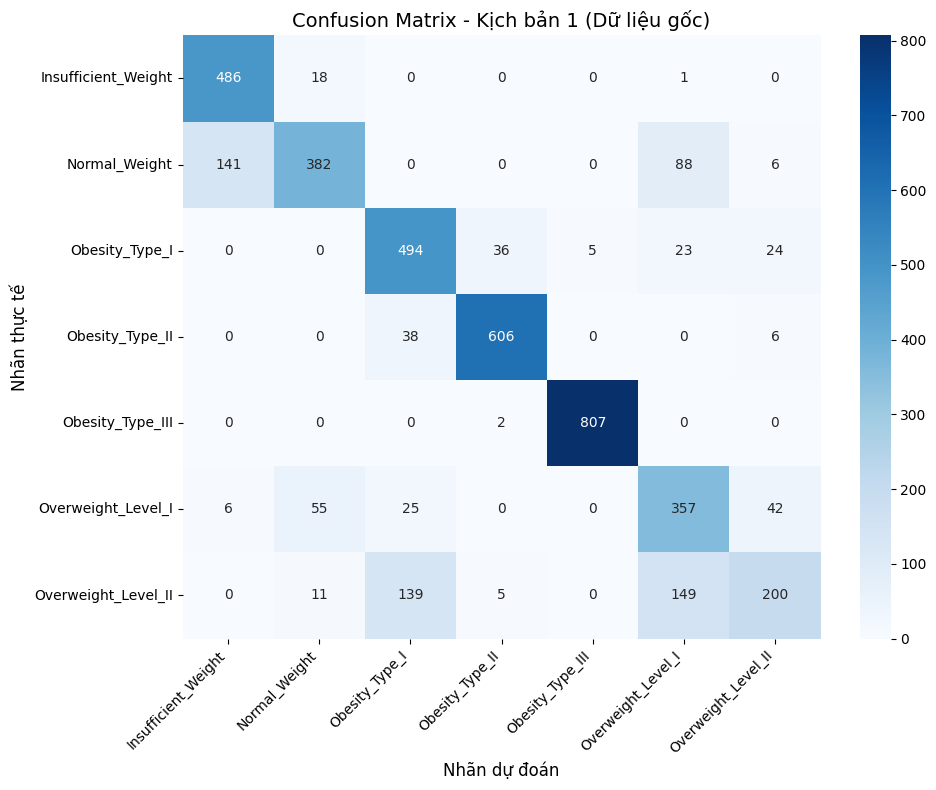

In [157]:
label_mapping = {
    0: 'Insufficient_Weight',
    1: 'Normal_Weight',
    2: 'Obesity_Type_I',
    3: 'Obesity_Type_II',
    4: 'Obesity_Type_III',
    5: 'Overweight_Level_I',
    6: 'Overweight_Level_II'
}

# Lấy danh sách tên nhãn theo thứ tự
labels = [label_mapping[i] for i in range(len(label_mapping))]

# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test_1, y_pred_1)

# Vẽ ma trận nhầm lẫn với nhãn đầy đủ
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=labels, yticklabels=labels
)
plt.title('Confusion Matrix - Kịch bản 1 (Dữ liệu gốc)', fontsize=14)
plt.xlabel('Nhãn dự đoán', fontsize=12)
plt.ylabel('Nhãn thực tế', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()